In [2]:
import pandas as pd
import urllib #package required to interact with live webpage 
import json
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima import arima
from pmdarima import model_selection
from pmdarima import pipeline
from pmdarima import preprocessing
from pmdarima.datasets._base import load_date_example
from pmdarima.utils import tsdisplay


In [3]:
url = "https://services.swpc.noaa.gov/json/goes/primary/xrays-7-day.json"

response = urllib.request.urlopen(url)

data = json.loads(response.read())


In [4]:
df16 = pd.DataFrame.from_dict(data)
df16 = df16[df16.energy != '0.05-0.4nm']
df16.drop(['satellite','observed_flux', 'electron_correction', 'electron_contaminaton','energy'], inplace=True, axis=1)
df16.columns =['time_tag','xrsb_16']

In [5]:
df16['time_tag']=pd.to_datetime(df16['time_tag'])
 
df16['time_tag'] =df16['time_tag'].dt.strftime('%Y-%m-%d %H:%M:%S')
df16['time_tag']=pd.to_datetime(df16['time_tag'])


df16['time_tag'].head()

1   2022-06-28 15:00:00
3   2022-06-28 15:01:00
5   2022-06-28 15:02:00
7   2022-06-28 15:03:00
9   2022-06-28 15:04:00
Name: time_tag, dtype: datetime64[ns]

In [6]:
df16[df16['xrsb_16']==0]=np.nan
df16.xrsb_16.isnull().sum()

0

In [7]:
df16.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10077 entries, 1 to 20153
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   time_tag  10077 non-null  datetime64[ns]
 1   xrsb_16   10077 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 236.2 KB


In [8]:
df16 = df16.set_index('time_tag')
df16.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10077 entries, 2022-06-28 15:00:00 to 2022-07-05 14:56:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   xrsb_16  10077 non-null  float64
dtypes: float64(1)
memory usage: 157.5 KB


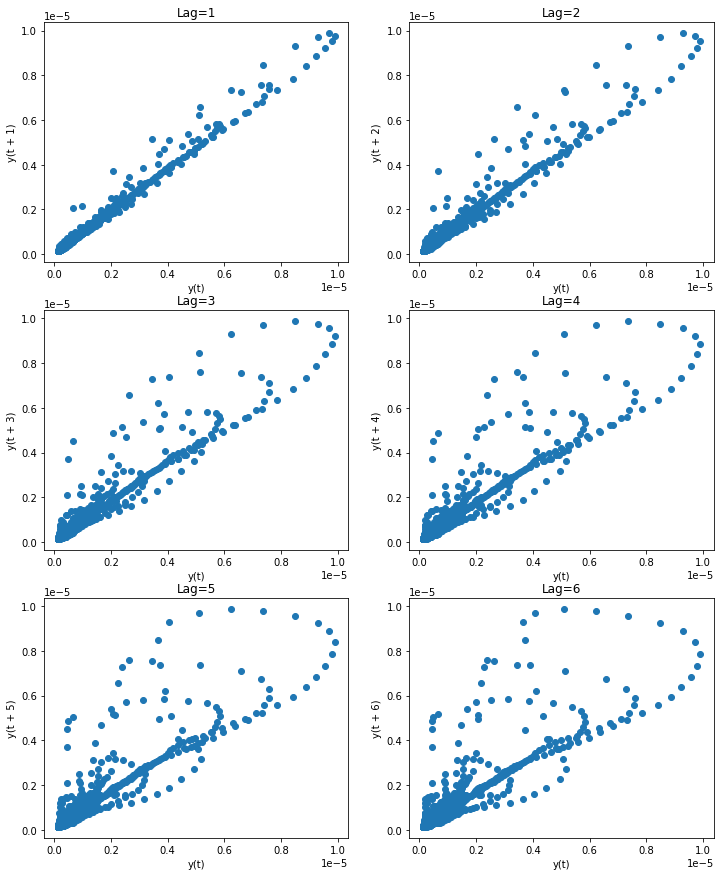

In [9]:
from pandas.plotting import lag_plot

fig, axes = plt.subplots(3, 2, figsize=(12, 15))
plt.title('MSFT Autocorrelation plot')

# The axis coordinates for the plots
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(df16['xrsb_16'], lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")

    
plt.savefig('lags.pdf')
    
plt.show()



   - A linear shape to the plot suggests that an autoregressive model is probably a better choice.
   - An elliptical plot suggests that the data comes from a single-cycle sinusoidal model.


In [10]:
### Stationarity 

# Import augmented dicky-fuller test function
from statsmodels.tsa.stattools import adfuller, kpss

def check_stationarity(series):
   # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Num of lags: %f' % result[2])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")
        
     # KPSS test
    statistic, p_value, n_lags, critical_values = kpss(series.values)
    # Format Output
    print(f'KPSS Statistic: {round(statistic,3)}') 
    print(f'p-value: {p_value}')
    print(f'n_lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f' {key} : {value}') 
    if p_value < 0.05:

        print('Probably not stationary\n') 
    else:

        print('Probably stationary\n') 

In [11]:
y = df16['xrsb_16'].squeeze()

In [12]:
train_len = int(np.round(0.90*len(y),0))
y_train, y_test = train_test_split(y, train_size=train_len)

## Raw Data

/usr/local/lib/python3.7/dist-packages/pmdarima/utils/visualization.py:223: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  vlines_kwargs=vlines_kwargs, **kwargs)


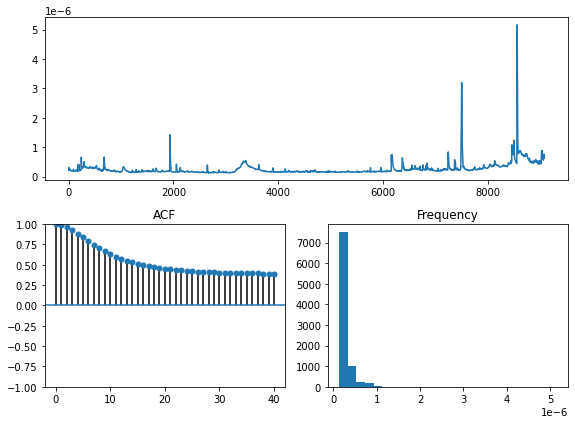

In [13]:
tsdisplay(y_train, lag_max=40)

In [14]:
from scipy.stats import normaltest
normaltest(y_train)#[1]

NormaltestResult(statistic=13932.32350466295, pvalue=0.0)

In [15]:
check_stationarity(y_train)

ADF Statistic: -8.908683
p-value: 0.000000
Num of lags: 24.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary
KPSS Statistic: 4.092
p-value: 0.01
n_lags: 55
Critial Values:
 10% : 0.347
 5% : 0.463
 2.5% : 0.574
 1% : 0.739
Probably not stationary



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


In [16]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")
# Estimated differencing term: 1

Estimated differencing term: 1


####### Auto ARIMA
auto = pm.auto_arima(y_train, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

## Transform - Diff

/usr/local/lib/python3.7/dist-packages/pmdarima/utils/visualization.py:223: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  vlines_kwargs=vlines_kwargs, **kwargs)


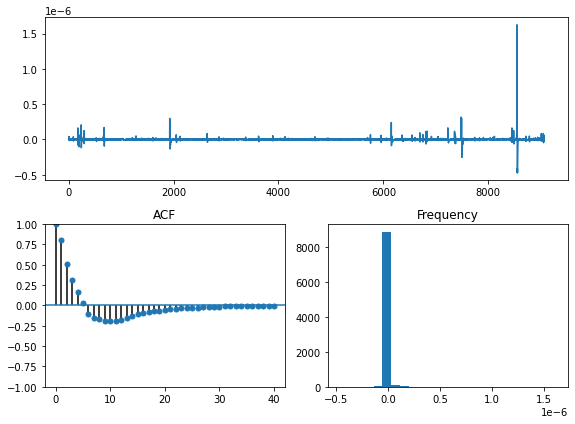

In [17]:
######### Calculate the first difference of the time series
xrsb_diff = y_train.diff().dropna()
#.diff()

tsdisplay(xrsb_diff, lag_max=40)

In [18]:
normaltest(xrsb_diff)#[1]

NormaltestResult(statistic=21290.39533211256, pvalue=0.0)

In [19]:
check_stationarity(xrsb_diff)

ADF Statistic: -21.937198
p-value: 0.000000
Num of lags: 37.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary
KPSS Statistic: 0.004
p-value: 0.1
n_lags: 22
Critial Values:
 10% : 0.347
 5% : 0.463
 2.5% : 0.574
 1% : 0.739
Probably stationary



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [20]:
auto = pm.auto_arima(xrsb_diff, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-192122.450, Time=3.51 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-192130.450, Time=0.48 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-231025.721, Time=0.98 sec


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-192128.450, Time=1.37 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-230209.676, Time=2.48 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-233745.925, Time=2.52 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-230105.797, Time=3.00 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-233792.900, Time=3.17 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-232634.072, Time=2.72 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-230580.963, Time=4.02 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-230648.786, Time=3.39 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-230640.285, Time=4.53 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-217325.697, Time=8.49 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]          
Total fit time: 40.685 seconds


In [21]:
print(auto.order)

(1, 0, 2)


In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df16['xrsb_16'], order=(1, 1, 0))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)


In [23]:
results = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [24]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                xrsb_16   No. Observations:                10077
Model:               SARIMAX(1, 1, 0)   Log Likelihood              125582.587
Date:                Tue, 05 Jul 2022   AIC                        -251161.174
Time:                        15:01:46   BIC                        -251146.739
Sample:                    06-28-2022   HQIC                       -251156.290
                         - 07-05-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8373   2.33e-19   3.59e+18      0.000       0.837       0.837
sigma2      1.047e-13   3.27e-11      0.003      0.997   -6.41e-11    6.43e-11
Ljung-Box (L1) (Q):                4363.77   Jarque-

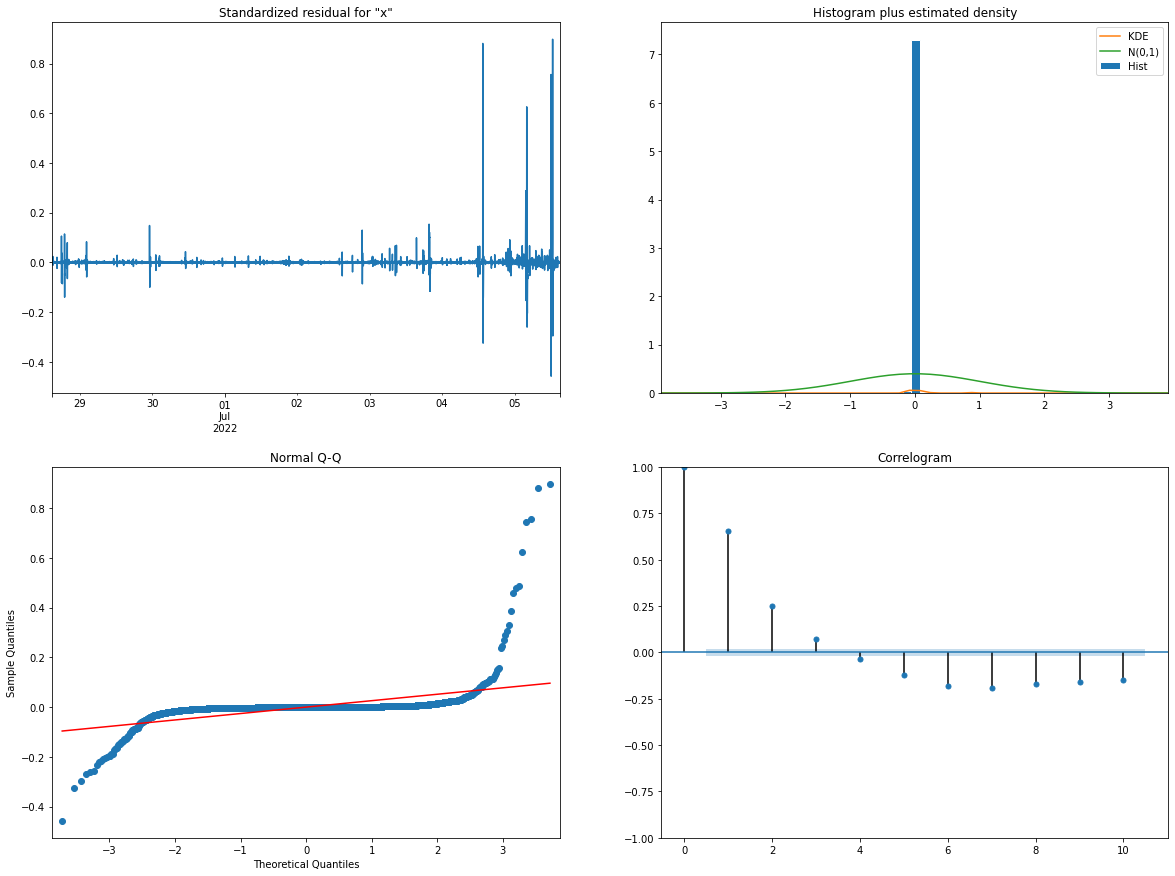

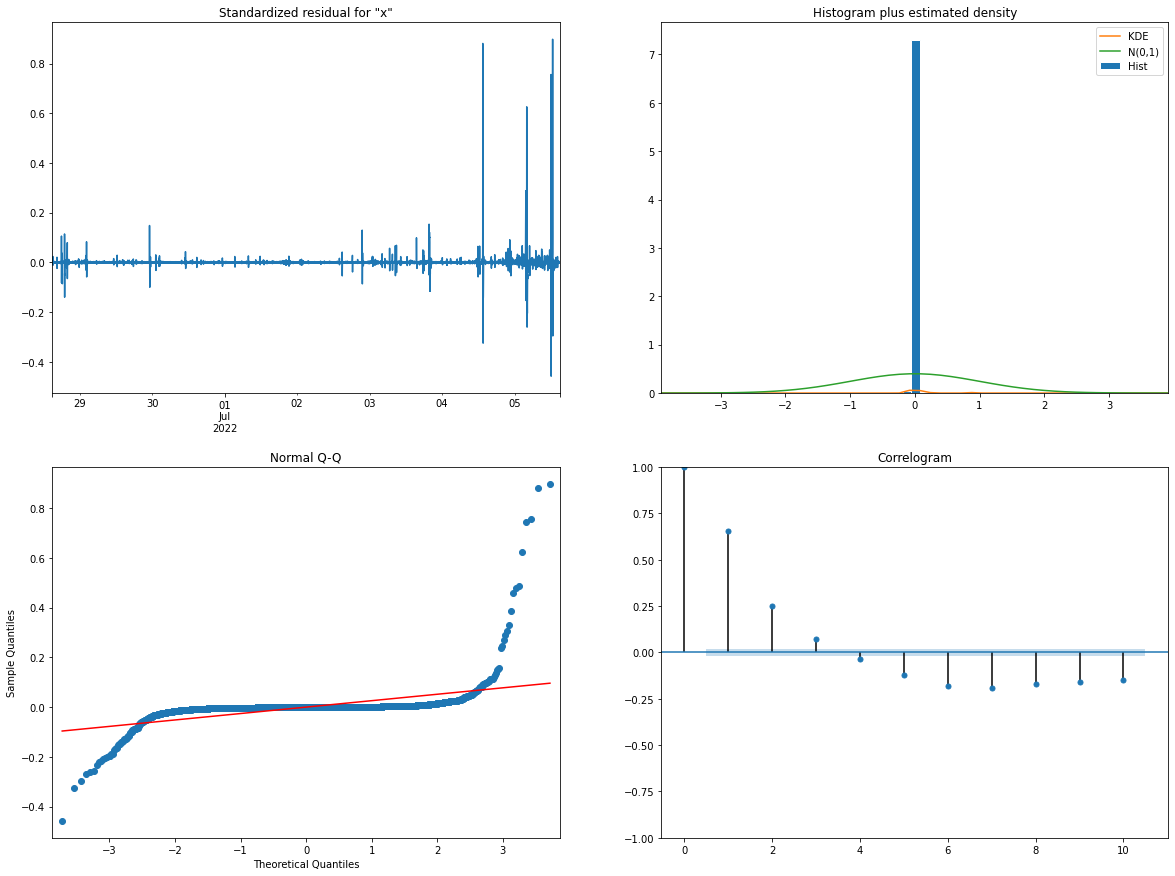

In [25]:
results.plot_diagnostics(figsize=(20, 15))

### Generating one-step-ahead predictions

In [26]:
#### One step ahead

forecast = results.get_prediction(start=-len(y_test))

#forescast mean
mean_forecast = forecast.predicted_mean


# Get confidence intervals of  predictions
confidence_intervals = forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower xrsb_16']
upper_limits = confidence_intervals.loc[:,'upper xrsb_16']

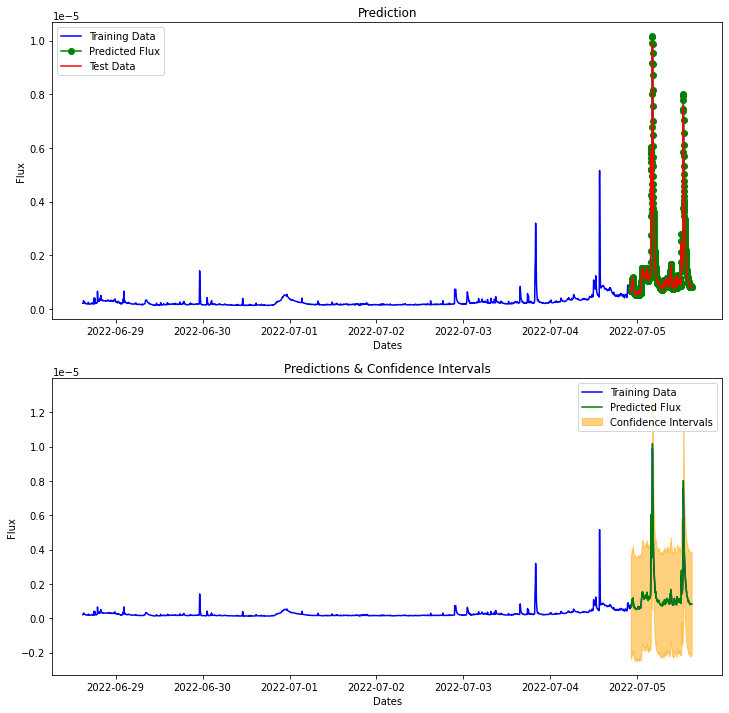

In [27]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))


axes[0].plot(df16.index, df16['xrsb_16'], label='Training Data', color='blue')

# plot your mean predictions
axes[0].plot(mean_forecast.index, mean_forecast, label='Predicted Flux',color='green', marker='o')

axes[0].plot(df16[-len(y_test):].index, df16['xrsb_16'][-len(y_test):], label='Test Data', color='red')

axes[0].set_title('Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Flux')


axes[0].legend()



axes[1].plot(df16.index, df16['xrsb_16'], label='Training Data', color='blue')

# plot your mean predictions
axes[1].plot(mean_forecast.index, mean_forecast, label='Predicted Flux',color='green')




# shade the area between your confidence limits
axes[1].fill_between(lower_limits.index, lower_limits,upper_limits, alpha=0.5, color='orange',
                     label="Confidence Intervals")


axes[1].set_title('Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Flux')
axes[1].legend()


In [28]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from pmdarima.metrics import smape

print(f"Mean squared error: {mean_squared_error(y_test, mean_forecast)}")
print(f"SMAPE: {smape(y_test, mean_forecast)}")
print(f"R2: {r2_score(y_test, mean_forecast)}")

Mean squared error: 1.0350039886438554e-14
SMAPE: 1.5511074701303227
R2: 0.9942296644139713


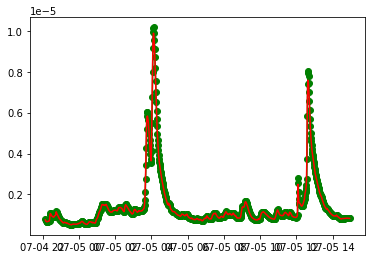

In [29]:
plt.plot(mean_forecast.index, mean_forecast, label='Predicted Flux',color='green', marker='o')

plt.plot(df16[-len(y_test):].index, df16['xrsb_16'][-len(y_test):], label='Test Data', color='red')

### Generating dynamic forecasts

In [30]:
# Generate predictions
dynamic_forecast = results.get_prediction(start=-len(y_test), dynamic=True)

# Extract prediction mean
mean_forecast = dynamic_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = dynamic_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower xrsb_16']
upper_limits = confidence_intervals.loc[:,'upper xrsb_16']

# Print best estimate predictions
#print(mean_forecast.values)

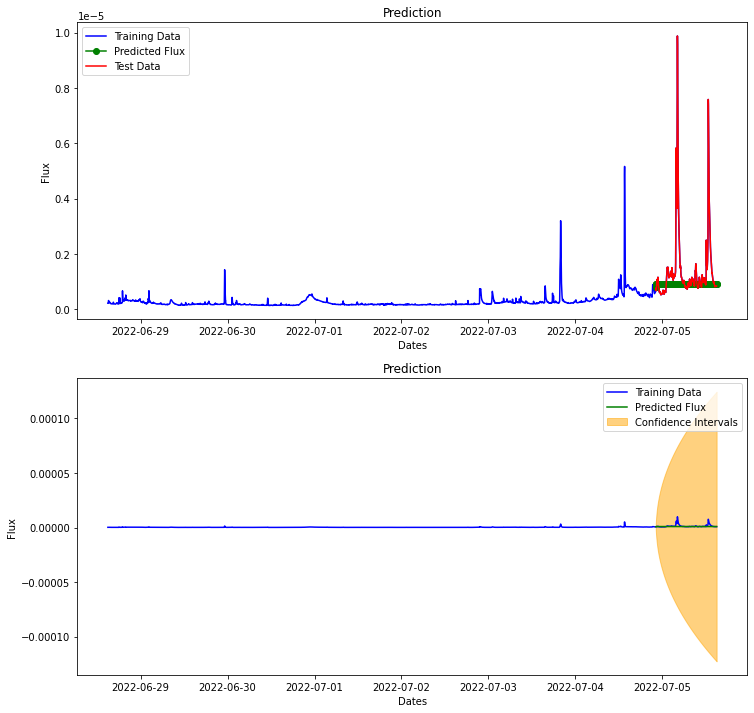

In [31]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))



axes[0].plot(df16.index, df16['xrsb_16'], label='Training Data', color='blue')

# plot your mean predictions
axes[0].plot(mean_forecast.index, mean_forecast, label='Predicted Flux',color='green', marker='o')

axes[0].plot(df16[-len(y_test):].index, df16['xrsb_16'][-len(y_test):], label='Test Data', color='red')

axes[0].set_title('Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Flux')


axes[0].legend()



axes[1].plot(df16.index, df16['xrsb_16'], label='Training Data', color='blue')

# plot your mean predictions
axes[1].plot(mean_forecast.index, mean_forecast, label='Predicted Flux',color='green')




# shade the area between your confidence limits
axes[1].fill_between(lower_limits.index, lower_limits,upper_limits, alpha=0.5, color='orange',
                     label="Confidence Intervals")

axes[1].set_title('Prediction')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Flux')
axes[1].legend()

In [32]:
print(f"Mean squared error: {mean_squared_error(y_test, mean_forecast)}")
print(f"SMAPE: {smape(y_test, mean_forecast)}")

print(f"R2: {r2_score(y_test, mean_forecast)}")

Mean squared error: 2.0358507528875616e-12
SMAPE: 34.40453919227155
R2: -0.13502384301175963


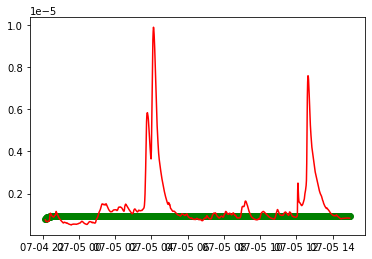

In [33]:
plt.plot(mean_forecast.index, mean_forecast, label='Predicted Flux',color='green', marker='o')

plt.plot(df16[-len(y_test):].index, df16['xrsb_16'][-len(y_test):], label='Test Data', color='red')

### Forecasting out of sample

In [34]:
# Generate predictions
out_forecast = results.get_forecast(steps=20)

# Extract prediction mean
mean_forecast = out_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = out_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower xrsb_16']
upper_limits = confidence_intervals.loc[:,'upper xrsb_16']

# Print best estimate predictions
#print(mean_forecast.values)

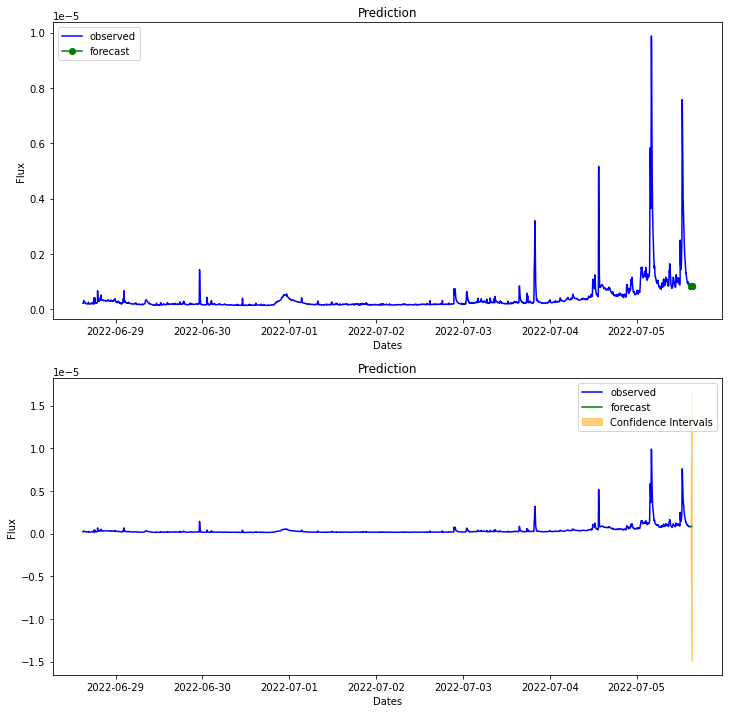

In [35]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))



axes[0].plot(df16.index, df16['xrsb_16'], label='observed', color='blue')

# plot your mean predictions
axes[0].plot(mean_forecast.index, mean_forecast, label='forecast',color='green', marker='o')


axes[0].set_title('Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Flux')


axes[0].legend()



axes[1].plot(df16.index, df16['xrsb_16'], label='observed', color='blue')

# plot your mean predictions
axes[1].plot(mean_forecast.index, mean_forecast, label='forecast',color='green')




# shade the area between your confidence limits
axes[1].fill_between(lower_limits.index, lower_limits,upper_limits, alpha=0.5, color='orange',
                     label="Confidence Intervals")

axes[1].set_title('Prediction')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Flux')
axes[1].legend()

## Transform - Log Difference


$$ log_{xrsb} (Y_t) = log\left(\frac{Y_t}{Y_{t-1}}\right) $$


/usr/local/lib/python3.7/dist-packages/pmdarima/utils/visualization.py:223: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  vlines_kwargs=vlines_kwargs, **kwargs)


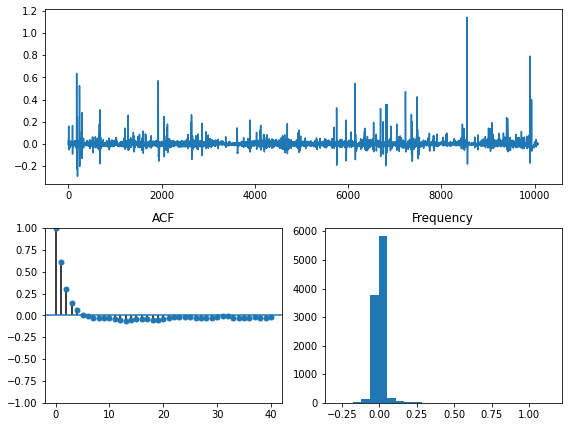

In [36]:
xrsb_log = np.log(df16['xrsb_16']/df16['xrsb_16'].shift(1))
xrsb_log = xrsb_log.dropna()

tsdisplay(xrsb_log, lag_max=40)

In [37]:
normaltest(xrsb_log)#[1]

NormaltestResult(statistic=13947.010631294284, pvalue=0.0)

In [38]:
check_stationarity(xrsb_log)

ADF Statistic: -20.568711
p-value: 0.000000
Num of lags: 32.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary
KPSS Statistic: 0.014
p-value: 0.1
n_lags: 25
Critial Values:
 10% : 0.347
 5% : 0.463
 2.5% : 0.574
 1% : 0.739
Probably stationary



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [39]:
auto = pm.auto_arima(xrsb_log, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-42150.783, Time=1.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-37332.186, Time=0.43 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-42039.387, Time=0.28 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-41171.944, Time=0.79 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-42151.958, Time=1.73 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-41976.852, Time=2.52 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-42149.040, Time=0.65 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-42149.944, Time=2.89 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-42106.468, Time=1.73 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-42152.092, Time=0.83 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-42153.926, Time=0.70 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-42152.083, Time=0.89 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-42150.181, Time=1.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-42151.965, Time=1.62 sec

Best

In [40]:
model = SARIMAX(xrsb_log, order=(2, 0, 0))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)


In [41]:
results = model.fit()

In [42]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                xrsb_16   No. Observations:                10076
Model:               SARIMAX(2, 0, 0)   Log Likelihood               21079.963
Date:                Tue, 05 Jul 2022   AIC                         -42153.926
Time:                        15:02:10   BIC                         -42132.272
Sample:                    06-28-2022   HQIC                        -42146.599
                         - 07-05-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6766      0.002    378.386      0.000       0.673       0.680
ar.L2         -0.1072      0.003    -40.722      0.000      -0.112      -0.102
sigma2         0.0009   1.38e-06    647.491      0.0

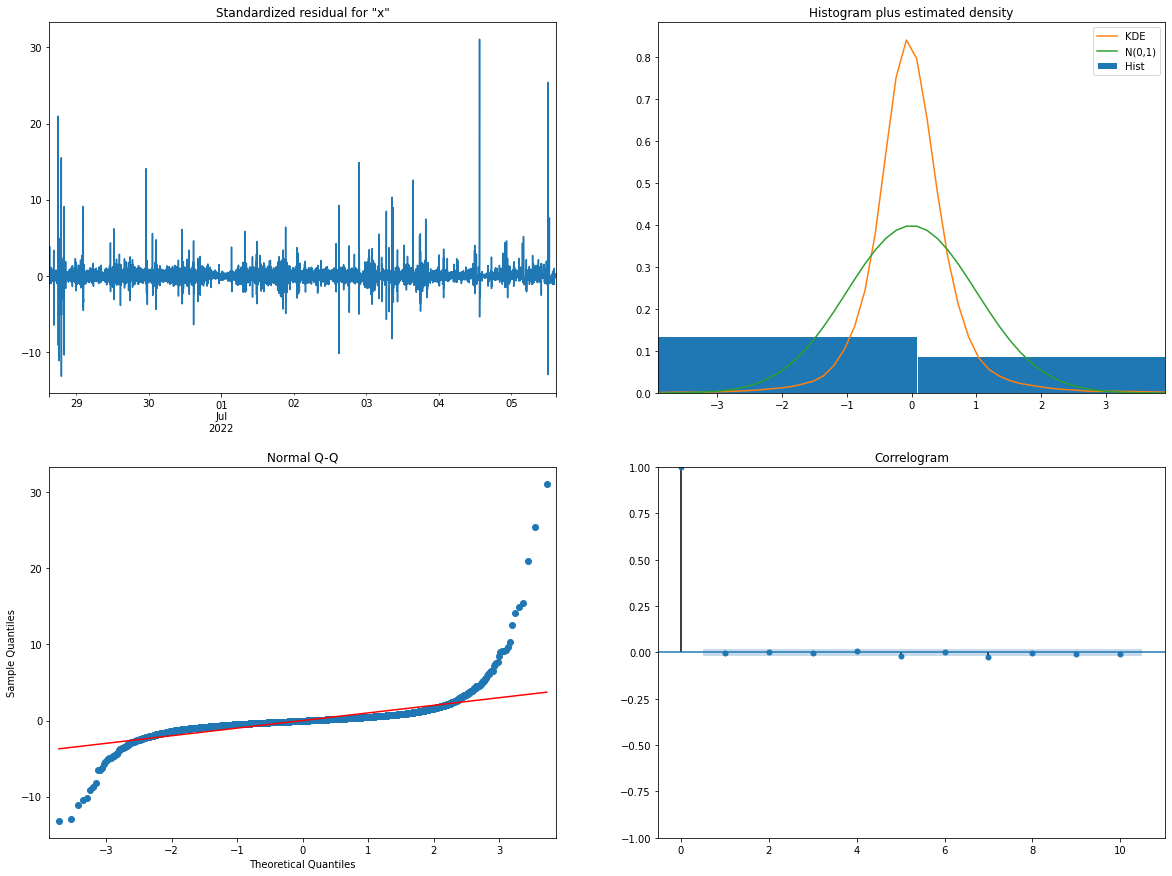

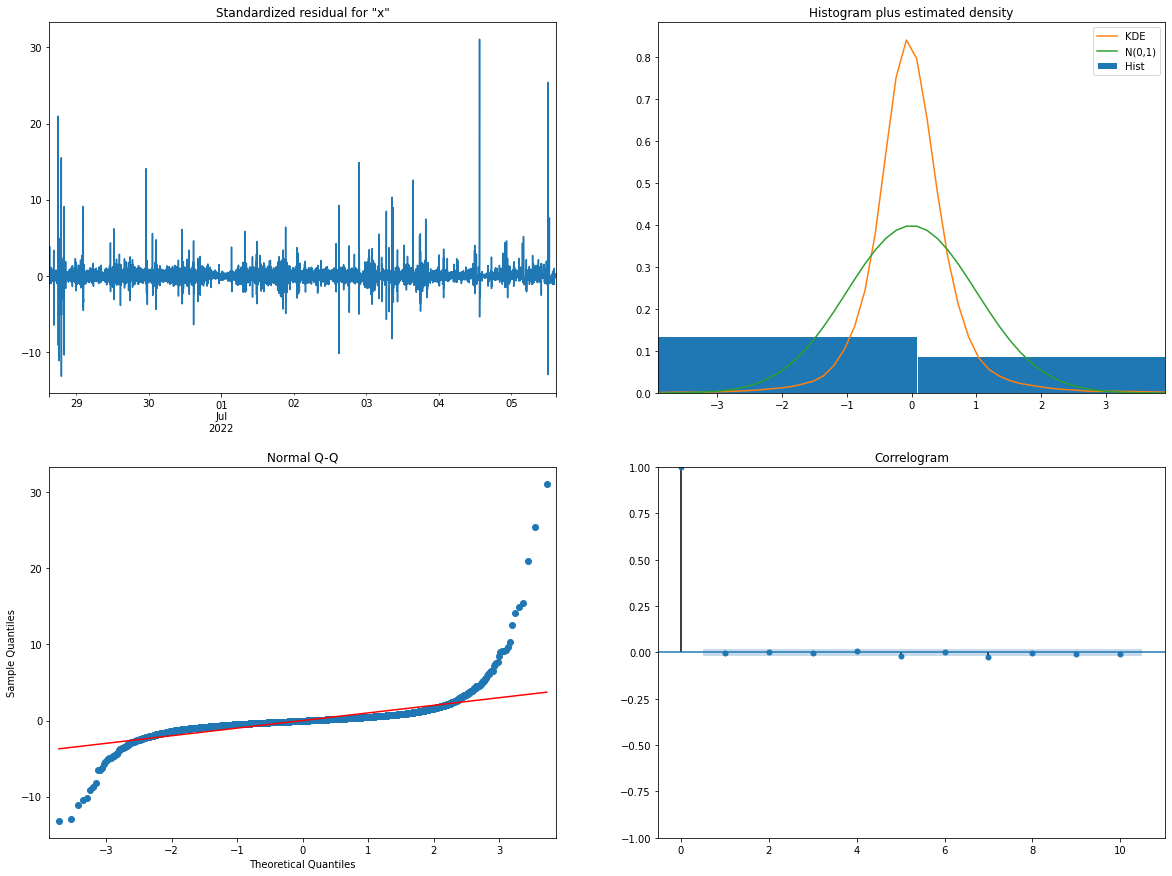

In [43]:
results.plot_diagnostics(figsize=(20, 15))

### Generating one-step-ahead predictions

In [44]:
#### One step ahead

forecast = results.get_prediction(start=-len(y_test))

#forescast mean
mean_forecast = forecast.predicted_mean


# Get confidence intervals of  predictions
confidence_intervals = forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower xrsb_16']
upper_limits = confidence_intervals.loc[:,'upper xrsb_16']

In [45]:
xrsb_log.head()

time_tag
2022-06-28 15:01:00    0.026757
2022-06-28 15:02:00    0.016287
2022-06-28 15:03:00   -0.012904
2022-06-28 15:04:00    0.002222
2022-06-28 15:05:00   -0.008580
Name: xrsb_16, dtype: float64

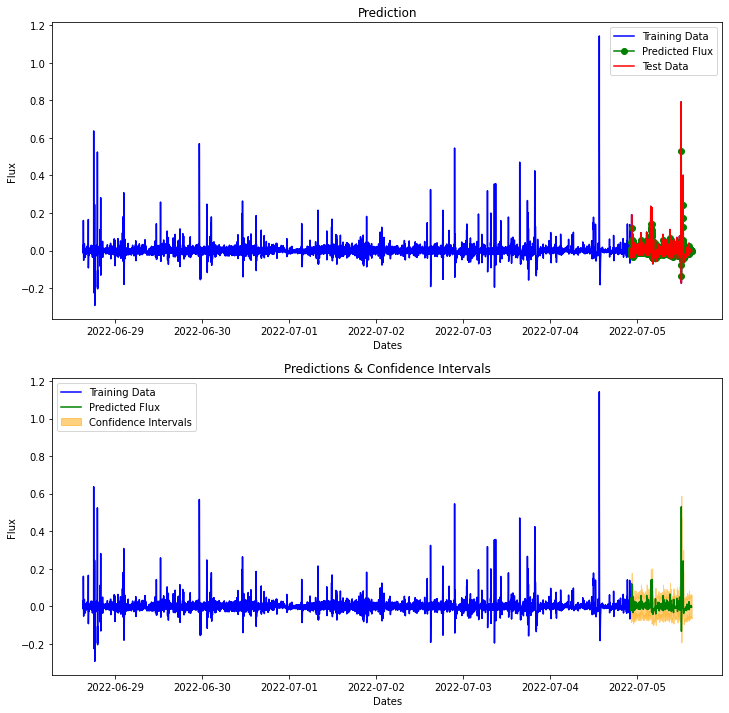

In [46]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))



axes[0].plot(xrsb_log.index, xrsb_log.values, label='Training Data', color='blue')

# plot your mean predictions
axes[0].plot(mean_forecast.index, mean_forecast, label='Predicted Flux',color='green', marker='o')

axes[0].plot(xrsb_log[-len(y_test):].index, xrsb_log[-len(y_test):].values, label='Test Data', color='red')

axes[0].set_title('Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Flux')


axes[0].legend()


axes[1].plot(xrsb_log[:-len(y_test)].index, xrsb_log[:-len(y_test)].values, label='Training Data', color='blue')

# plot your mean predictions
axes[1].plot(mean_forecast.index, mean_forecast, label='Predicted Flux',color='green')




# shade the area between your confidence limits
axes[1].fill_between(lower_limits.index, lower_limits,upper_limits, alpha=0.5, color='orange',
                     label="Confidence Intervals")


axes[1].set_title('Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Flux')
axes[1].legend()


In [47]:
print(f"Mean squared error: {mean_squared_error(xrsb_log[-len(y_test):], mean_forecast)}")
print(f"SMAPE: {smape(xrsb_log[-len(y_test):], mean_forecast)}")

print(f"R2: {r2_score(xrsb_log[-len(y_test):], mean_forecast)}")

Mean squared error: 0.0012171468120567778
SMAPE: 87.49788148286802
R2: 0.4249954562077355


### Generating dynamic forecasts

In [48]:
# Generate predictions
dynamic_forecast = results.get_prediction(start=-len(y_test), dynamic=True)

# Extract prediction mean
mean_forecast = dynamic_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = dynamic_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower xrsb_16']
upper_limits = confidence_intervals.loc[:,'upper xrsb_16']

# Print best estimate predictions
#print(mean_forecast.values)

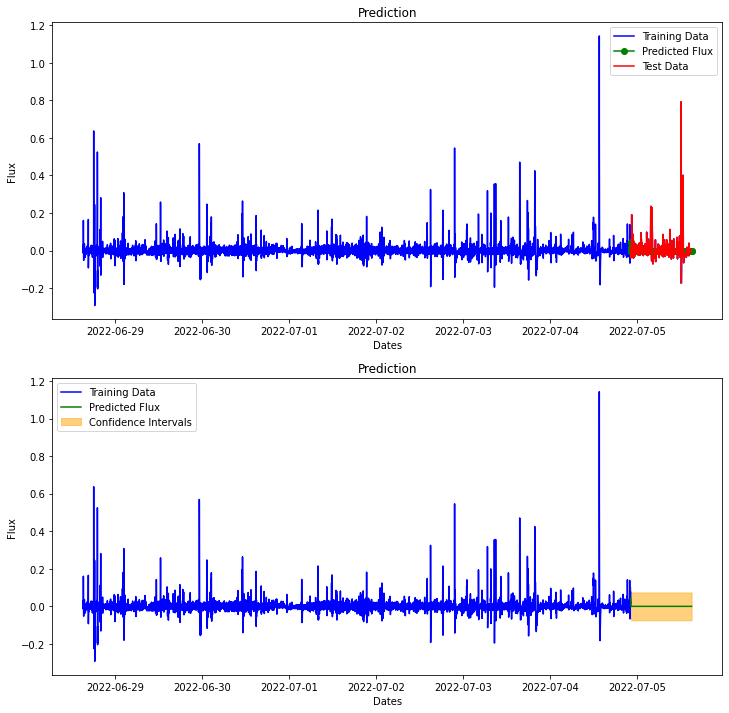

In [49]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))



axes[0].plot(xrsb_log.index, xrsb_log.values, label='Training Data', color='blue')

# plot your mean predictions
axes[0].plot(mean_forecast.index, mean_forecast, label='Predicted Flux',color='green', marker='o')

axes[0].plot(xrsb_log[-len(y_test):].index, xrsb_log[-len(y_test):].values, label='Test Data', color='red')

axes[0].set_title('Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Flux')


axes[0].legend()



axes[1].plot(xrsb_log[:-len(y_test)].index, xrsb_log[:-len(y_test)].values, label='Training Data', color='blue')


# plot your mean predictions
axes[1].plot(mean_forecast.index, mean_forecast, label='Predicted Flux',color='green')




# shade the area between your confidence limits
axes[1].fill_between(lower_limits.index, lower_limits,upper_limits, alpha=0.5, color='orange',
                     label="Confidence Intervals")

axes[1].set_title('Prediction')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Flux')
axes[1].legend()

In [50]:
print(f"Mean squared error: {mean_squared_error(xrsb_log[-len(y_test):], mean_forecast)}")
print(f"SMAPE: {smape(xrsb_log[-len(y_test):], mean_forecast)}")
print(f"R2: {r2_score(xrsb_log[-len(y_test):], mean_forecast)}")

Mean squared error: 0.002122074880080307
SMAPE: 199.79962503963733
R2: -0.00251069651298641


### Forecasting out of sample

In [51]:
# Generate predictions
out_forecast = results.get_forecast(steps=20)

# Extract prediction mean
mean_forecast = out_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = out_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower xrsb_16']
upper_limits = confidence_intervals.loc[:,'upper xrsb_16']

# Print best estimate predictions
#print(mean_forecast.values)

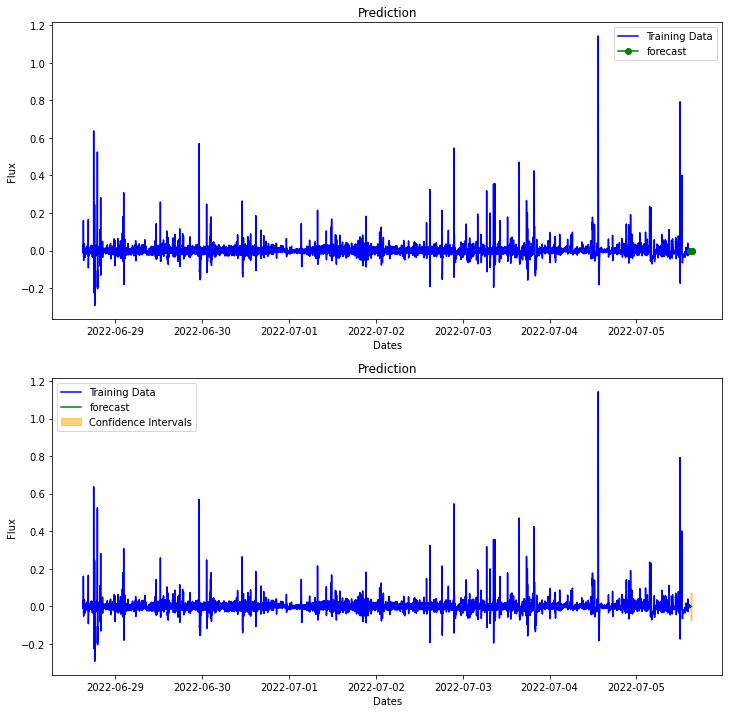

In [52]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))



axes[0].plot(xrsb_log.index, xrsb_log.values, label='Training Data', color='blue')

# plot your mean predictions
axes[0].plot(mean_forecast.index, mean_forecast, label='forecast',color='green', marker='o')


axes[0].set_title('Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Flux')


axes[0].legend()



axes[1].plot(xrsb_log.index, xrsb_log.values, label='Training Data', color='blue')

# plot your mean predictions
axes[1].plot(mean_forecast.index, mean_forecast, label='forecast',color='green')




# shade the area between your confidence limits
axes[1].fill_between(lower_limits.index, lower_limits,upper_limits, alpha=0.5, color='orange',
                     label="Confidence Intervals")

axes[1].set_title('Prediction')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Flux')
axes[1].legend()

### - Transformation: Proportional Change

/usr/local/lib/python3.7/dist-packages/pmdarima/utils/visualization.py:223: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  vlines_kwargs=vlines_kwargs, **kwargs)


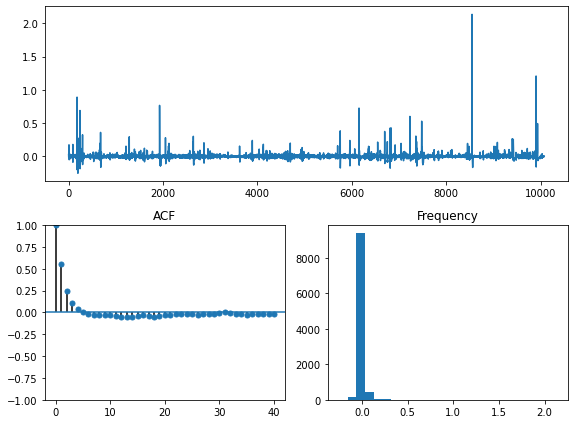

In [53]:
xrsb_pct = df16['xrsb_16'].pct_change().dropna()
tsdisplay(xrsb_pct, lag_max=40)

In [54]:
normaltest(xrsb_pct)#[1]

NormaltestResult(statistic=20299.04788394663, pvalue=0.0)

In [55]:
check_stationarity(xrsb_pct)

ADF Statistic: -26.021258
p-value: 0.000000
Num of lags: 17.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary
KPSS Statistic: 0.043
p-value: 0.1
n_lags: 22
Critial Values:
 10% : 0.347
 5% : 0.463
 2.5% : 0.574
 1% : 0.739
Probably stationary



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [56]:
auto = pm.auto_arima(xrsb_pct, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-37088.724, Time=5.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-33308.206, Time=0.46 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-37013.451, Time=0.28 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-36487.761, Time=0.95 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-37090.681, Time=1.63 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-36996.090, Time=2.16 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-37092.129, Time=1.89 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-37090.699, Time=1.59 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-37092.254, Time=0.65 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-37090.658, Time=0.95 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-37088.665, Time=2.21 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-37091.682, Time=1.94 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 19.763 seconds


In [57]:
model = SARIMAX(xrsb_pct, order=(3, 0, 2))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)


In [58]:
results = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [59]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                xrsb_16   No. Observations:                10076
Model:               SARIMAX(3, 0, 2)   Log Likelihood               18549.287
Date:                Tue, 05 Jul 2022   AIC                         -37086.573
Time:                        15:02:40   BIC                         -37043.266
Sample:                    06-28-2022   HQIC                        -37071.920
                         - 07-05-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2652      2.442      0.109      0.914      -4.521       5.051
ar.L2          0.0314      1.270      0.025      0.980      -2.458       2.521
ar.L3          0.0230      0.117      0.197      0.8

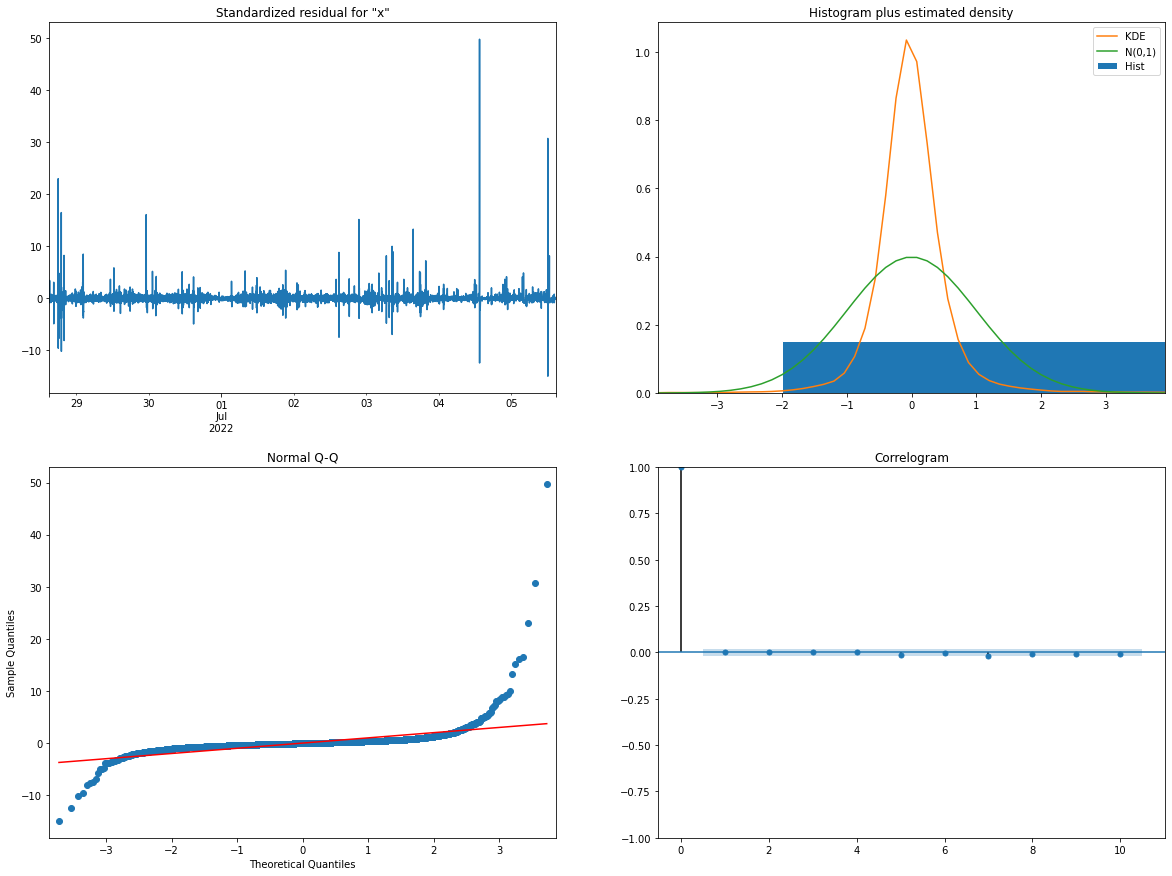

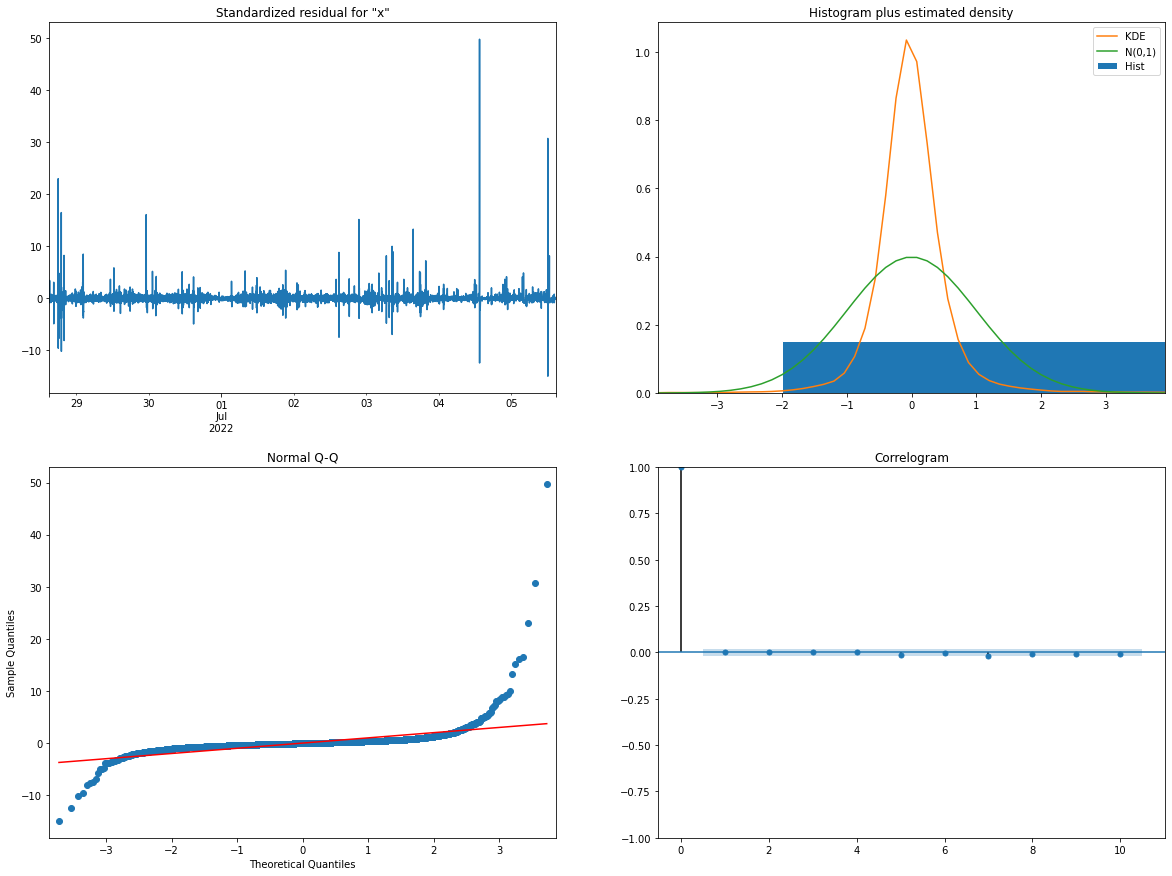

In [60]:
results.plot_diagnostics(figsize=(20, 15))

### Generating one-step-ahead predictions

In [61]:
#### One step ahead

forecast = results.get_prediction(start=-len(y_test))

#forescast mean
mean_forecast = forecast.predicted_mean


# Get confidence intervals of  predictions
confidence_intervals = forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower xrsb_16']
upper_limits = confidence_intervals.loc[:,'upper xrsb_16']

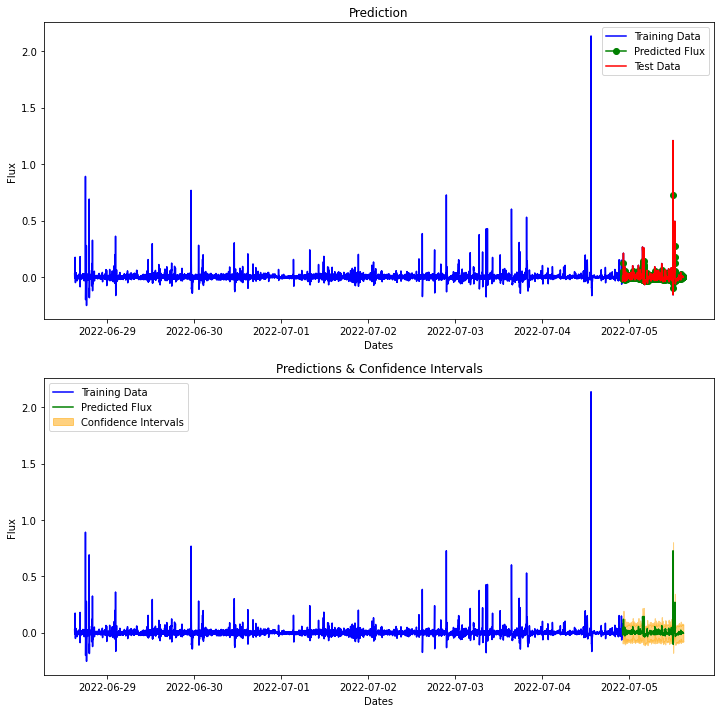

In [62]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))



axes[0].plot(xrsb_pct.index, xrsb_pct.values, label='Training Data', color='blue')

# plot your mean predictions
axes[0].plot(mean_forecast.index, mean_forecast, label='Predicted Flux',color='green', marker='o')

axes[0].plot(xrsb_pct[-len(y_test):].index, xrsb_pct[-len(y_test):].values, label='Test Data', color='red')

axes[0].set_title('Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Flux')


axes[0].legend()


axes[1].plot(xrsb_pct[:-len(y_test)].index, xrsb_pct[:-len(y_test)].values, label='Training Data', color='blue')

# plot your mean predictions
axes[1].plot(mean_forecast.index, mean_forecast, label='Predicted Flux',color='green')




# shade the area between your confidence limits
axes[1].fill_between(lower_limits.index, lower_limits,upper_limits, alpha=0.5, color='orange',
                     label="Confidence Intervals")


axes[1].set_title('Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Flux')
axes[1].legend()

In [63]:
print(f"Mean squared error: {mean_squared_error(xrsb_pct[-len(y_test):], mean_forecast)}")
print(f"SMAPE: {smape(xrsb_pct[-len(y_test):], mean_forecast)}")
print(f"R2: {r2_score(xrsb_pct[-len(y_test):], mean_forecast)}")

Mean squared error: 0.0023292032052798796
SMAPE: 92.18131408263518
R2: 0.2649188404967038


### Generating dynamic forecasts

In [64]:
# Generate predictions
dynamic_forecast = results.get_prediction(start=-len(y_test), dynamic=True)

# Extract prediction mean
mean_forecast = dynamic_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = dynamic_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower xrsb_16']
upper_limits = confidence_intervals.loc[:,'upper xrsb_16']

# Print best estimate predictions
#print(mean_forecast.values)

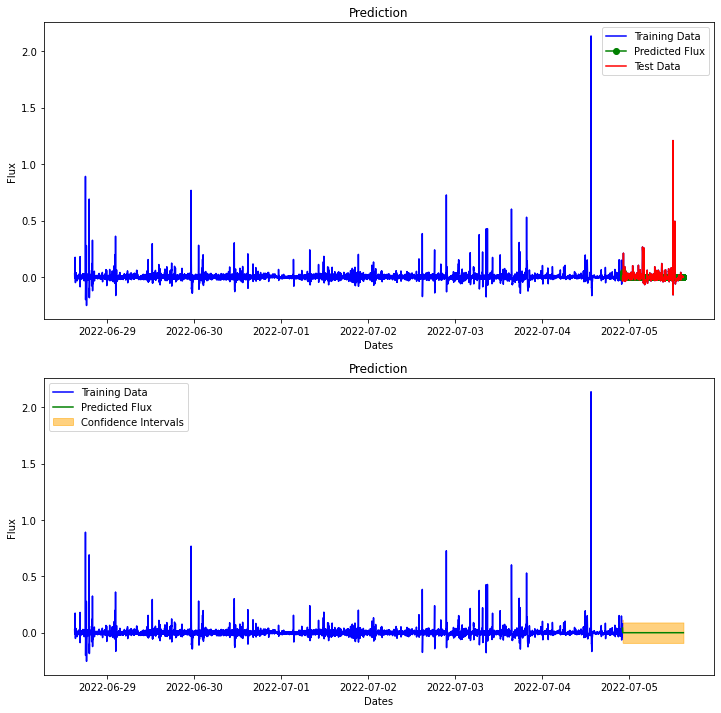

In [65]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))


axes[0].plot(xrsb_pct.index, xrsb_pct.values, label='Training Data', color='blue')

# plot your mean predictions
axes[0].plot(mean_forecast.index, mean_forecast, label='Predicted Flux',color='green', marker='o')

axes[0].plot(xrsb_pct[-len(y_test):].index, xrsb_pct[-len(y_test):].values, label='Test Data', color='red')

axes[0].set_title('Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Flux')


axes[0].legend()



axes[1].plot(xrsb_pct[:-len(y_test)].index, xrsb_pct[:-len(y_test)].values, label='Training Data', color='blue')


# plot your mean predictions
axes[1].plot(mean_forecast.index, mean_forecast, label='Predicted Flux',color='green')




# shade the area between your confidence limits
axes[1].fill_between(lower_limits.index, lower_limits,upper_limits, alpha=0.5, color='orange',
                     label="Confidence Intervals")

axes[1].set_title('Prediction')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Flux')
axes[1].legend()

In [66]:
print(f"Mean squared error: {mean_squared_error(xrsb_pct[-len(y_test):], mean_forecast)}")
print(f"SMAPE: {smape(xrsb_pct[-len(y_test):], mean_forecast)}")
print(f"R2: {r2_score(xrsb_pct[-len(y_test):], mean_forecast)}")

Mean squared error: 0.003174642792001731
SMAPE: 199.8118068581591
R2: -0.0018963134103209267


### Forecasting out of sample

In [67]:
# Generate predictions
out_forecast = results.get_forecast(steps=20)

# Extract prediction mean
mean_forecast = out_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = out_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower xrsb_16']
upper_limits = confidence_intervals.loc[:,'upper xrsb_16']

# Print best estimate predictions
#print(mean_forecast.values)

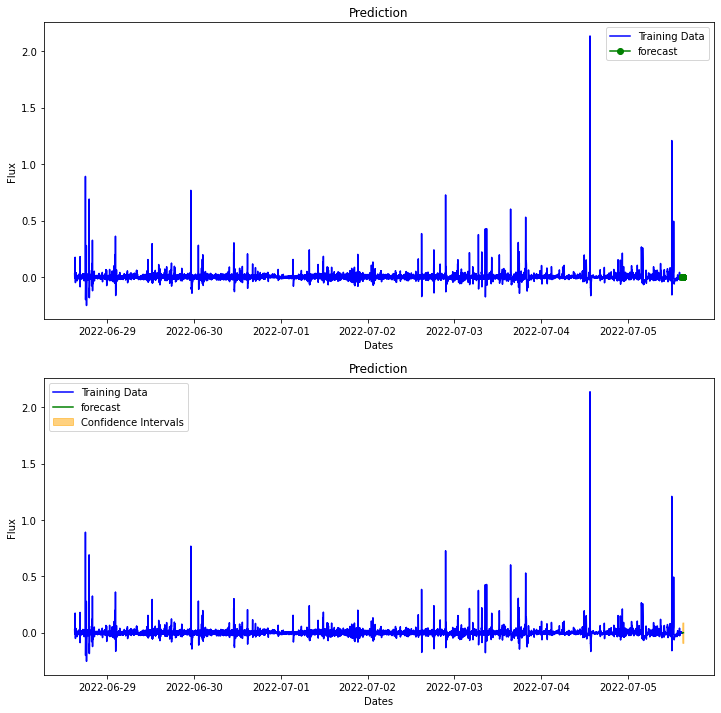

In [68]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))



axes[0].plot(xrsb_pct.index, xrsb_pct.values, label='Training Data', color='blue')

# plot your mean predictions
axes[0].plot(mean_forecast.index, mean_forecast, label='forecast',color='green', marker='o')


axes[0].set_title('Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Flux')


axes[0].legend()


axes[1].plot(xrsb_pct.index, xrsb_pct.values, label='Training Data', color='blue')

# plot your mean predictions
axes[1].plot(mean_forecast.index, mean_forecast, label='forecast',color='green')




# shade the area between your confidence limits
axes[1].fill_between(lower_limits.index, lower_limits,upper_limits, alpha=0.5, color='orange',
                     label="Confidence Intervals")

axes[1].set_title('Prediction')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Flux')
axes[1].legend()


### Transforming the data

Since we expect our model to perform better over more normal data, let’s experiment with log transformations and the Box-Cox transformation, each of which is provided as an endogenous transformer in the Pmdarima package.


/usr/local/lib/python3.7/dist-packages/pmdarima/utils/visualization.py:223: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  vlines_kwargs=vlines_kwargs, **kwargs)


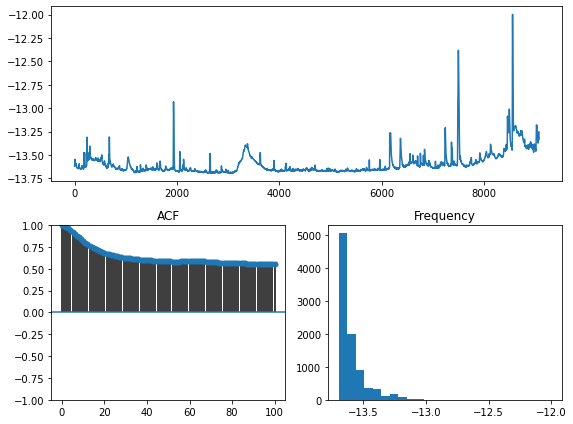

In [69]:
from pmdarima.preprocessing import LogEndogTransformer

y_train_log, _ = LogEndogTransformer(lmbda=1e-6).fit_transform(y_train)
tsdisplay(y_train_log, lag_max=100)

In [70]:

normaltest(y_train_log)#[1]

NormaltestResult(statistic=8161.246759146103, pvalue=0.0)

In [71]:
from pmdarima.pipeline import Pipeline

fit1 = Pipeline([
    ('logendog', LogEndogTransformer(lmbda=1e-6)),
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,stepwise=True))
])

fit1.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-60030.273, Time=16.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-52962.150, Time=1.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-59521.378, Time=1.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-58365.899, Time=5.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-52964.062, Time=0.41 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-60032.301, Time=1.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-59610.508, Time=8.28 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-60033.833, Time=2.94 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-60032.218, Time=3.67 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-59990.628, Time=1.36 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-60035.808, Time=1.28 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-58367.834, Time=1.41 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-59523.355, Time=0.36 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-60034.192, Time=1.48 sec
 ARI

Pipeline(steps=[('logendog', LogEndogTransformer(lmbda=1e-06)),
                ('arima', AutoARIMA(trace=True))])

In [72]:
print(fit1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 9069
Model:               SARIMAX(1, 1, 1)   Log Likelihood               30020.904
Date:                Tue, 05 Jul 2022   AIC                         -60035.808
Time:                        15:03:41   BIC                         -60014.470
Sample:                             0   HQIC                        -60028.550
                               - 9069                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5677      0.002    270.147      0.000       0.564       0.572
ma.L1          0.3262      0.003    127.647      0.000       0.321       0.331
sigma2      7.796e-05   5.98e-08   1304.486      0.0

/usr/local/lib/python3.7/dist-packages/pmdarima/utils/visualization.py:223: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  vlines_kwargs=vlines_kwargs, **kwargs)


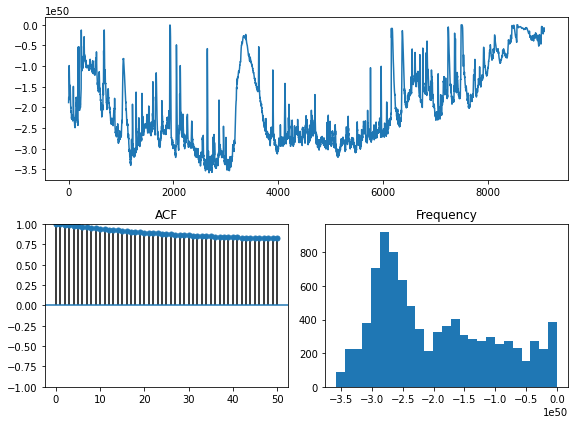

In [73]:
from pmdarima.preprocessing import BoxCoxEndogTransformer

y_train_bc, _ = BoxCoxEndogTransformer(lmbda2=1e-6).fit_transform(y_train)
#lmbda2=1e-6
tsdisplay(y_train_bc, lag_max=50)

In [74]:
normaltest(y_train_bc)#[1]

NormaltestResult(statistic=1654.456695917099, pvalue=0.0)

In [75]:
fit2 = Pipeline([
    ('boxcox', BoxCoxEndogTransformer(lmbda2=1e-6)),
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,stepwise=True))
])

fit2.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2064345.831, Time=1.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2066141.369, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2064367.239, Time=0.65 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2064627.579, Time=1.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2066139.437, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2064342.742, Time=3.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2064344.119, Time=1.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2064367.326, Time=1.85 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2064348.434, Time=1.85 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2064343.558, Time=1.68 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2064371.926, Time=1.93 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2064269.645, Time=11.61 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2064254.030, Time=13.05 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2064260.986, Tim

Pipeline(steps=[('boxcox', BoxCoxEndogTransformer(lmbda2=1e-06)),
                ('arima', AutoARIMA(trace=True))])

In [76]:
print(fit2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 9069
Model:               SARIMAX(4, 1, 2)   Log Likelihood            -1032118.921
Date:                Tue, 05 Jul 2022   AIC                        2064251.843
Time:                        15:08:22   BIC                        2064301.630
Sample:                             0   HQIC                       2064268.778
                               - 9069                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6514      0.050     13.063      0.000       0.554       0.749
ar.L2          0.6334      0.068      9.339      0.000       0.500       0.766
ar.L3         -0.3648      0.018    -20.353      0.0

In [77]:
from sklearn.metrics import mean_squared_error as mse

In [78]:
f1, conf_int = fit1.predict(n_periods=y_test.shape[0], return_conf_int=True)

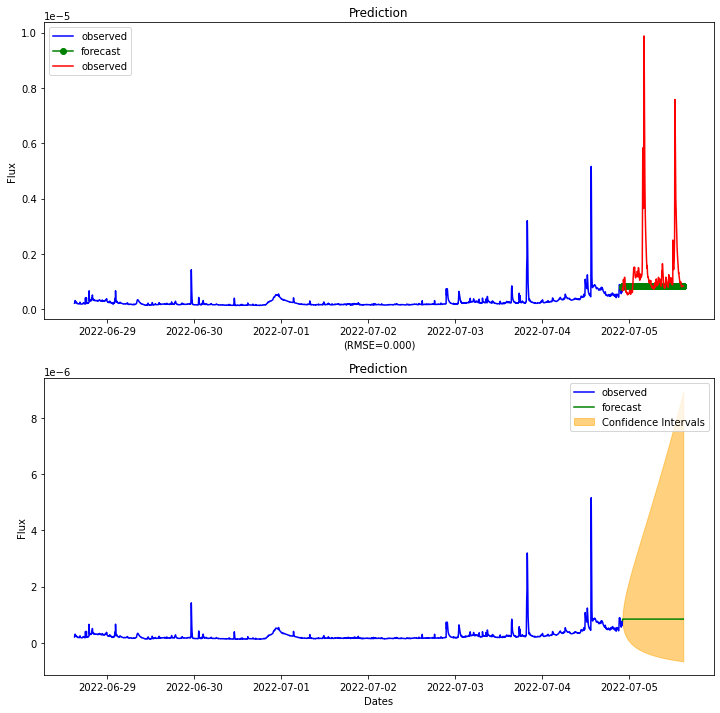

In [79]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))



axes[0].plot(y_train.index, y_train, label='observed', color='blue')

# plot your mean predictions
axes[0].plot(y_test.index, f1, label='forecast',color='green', marker='o')



axes[0].plot(y_test.index, y_test, label='observed', color='red')
axes[0].set_xlabel(f'(RMSE={np.sqrt(mse(y_test, f1)):.3f})')
axes[0].set_title('Prediction')
#axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Flux')


axes[0].legend()



axes[1].plot(y_train.index, y_train, label='observed', color='blue')

# plot your mean predictions
axes[1].plot(y_test.index, f1, label='forecast',color='green')

# shade the area between your confidence limits
axes[1].fill_between(y_test.index, conf_int[:, 0], conf_int[:, 1], alpha=0.5, color='orange',label="Confidence Intervals")

axes[1].set_title('Prediction')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Flux')


axes[1].legend()

Text(0.5, 1.0, 'Residuals (p=0.000)')

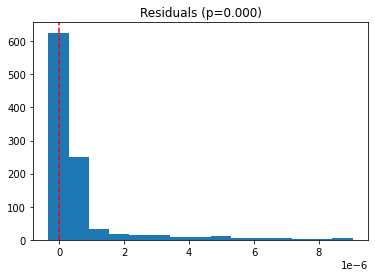

In [80]:
# Plot the residuals
resid = y_test - f1
_, p = normaltest(resid)
plt.hist(resid, bins=15)
plt.axvline(0, linestyle='--', c='r')
plt.title(f'Residuals (p={p:.3f})')

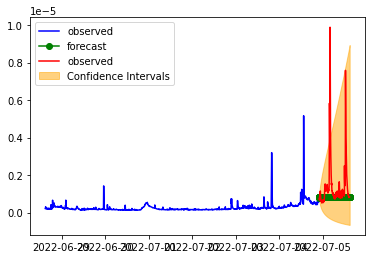

In [81]:

plt.plot(y_train.index, y_train, label='observed', color='blue')

# plot your mean predictions
plt.plot(y_test.index, f1, label='forecast',color='green', marker='o')



plt.plot(y_test.index, y_test, label='observed', color='red')


# shade the area between your confidence limits
plt.fill_between(y_test.index, conf_int[:, 0], conf_int[:, 1], alpha=0.5, color='orange',label="Confidence Intervals")

#plt.set_xlabel(f'(RMSE={np.sqrt(mse(y_test, f1)):.3f})')
#plt.set_title('Prediction')
#axes[0].set_xlabel('Dates')
#plt.set_ylabel('Flux')


plt.legend()

In [82]:
f2, conf_int = fit2.predict(n_periods=y_test.shape[0], return_conf_int=True)

/usr/local/lib/python3.7/dist-packages/pmdarima/preprocessing/endog/boxcox.py:174: RuntimeWarning: invalid value encountered in power
  de_exp = numer ** (1. / lam1)  # de-exponentiate


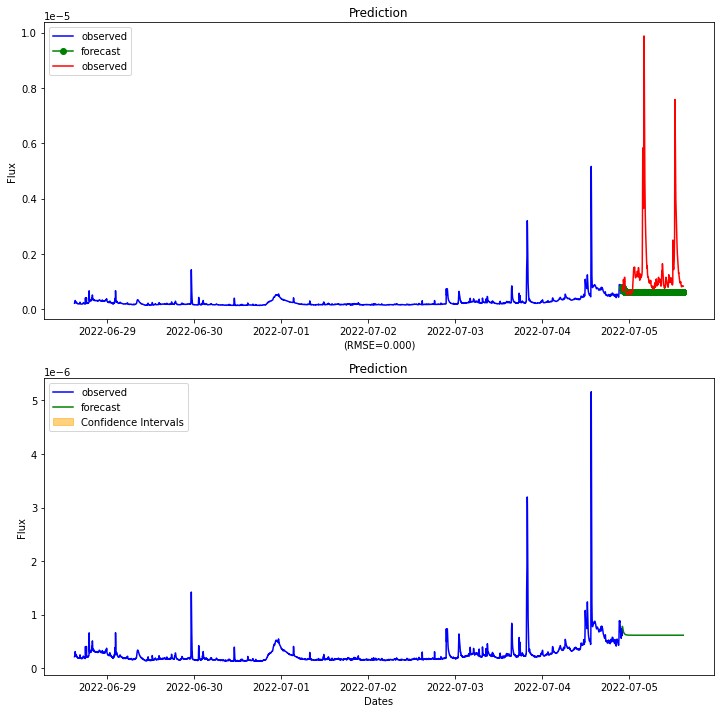

In [83]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))



axes[0].plot(y_train.index, y_train, label='observed', color='blue')

# plot your mean predictions
axes[0].plot(y_test.index, f2, label='forecast',color='green', marker='o')



axes[0].plot(y_test.index, y_test, label='observed', color='red')
axes[0].set_xlabel(f'(RMSE={np.sqrt(mse(y_test, f1)):.3f})')
axes[0].set_title('Prediction')
#axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Flux')


axes[0].legend()


axes[1].plot(y_train.index, y_train, label='observed', color='blue')

# plot your mean predictions
axes[1].plot(y_test.index, f2, label='forecast',color='green')

# shade the area between your confidence limits
axes[1].fill_between(y_test.index, conf_int[:, 0], conf_int[:, 1], alpha=0.5, color='orange',label="Confidence Intervals")

axes[1].set_title('Prediction')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Flux')


axes[1].legend()

Text(0.5, 1.0, 'Residuals (p=0.000)')

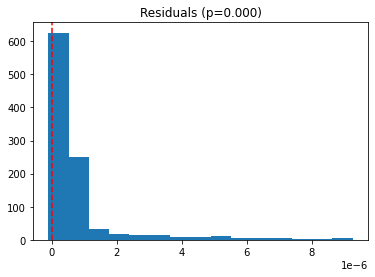

In [84]:
# Plot the residuals
resid = y_test - f2
_, p = normaltest(resid)
plt.hist(resid, bins=15)
plt.axvline(0, linestyle='--', c='r')
plt.title(f'Residuals (p={p:.3f})')

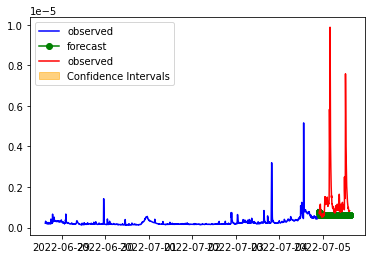

In [85]:

plt.plot(y_train.index, y_train, label='observed', color='blue')

# plot your mean predictions
plt.plot(y_test.index, f2, label='forecast',color='green', marker='o')



plt.plot(y_test.index, y_test, label='observed', color='red')


# shade the area between your confidence limits
plt.fill_between(y_test.index, conf_int[:, 0], conf_int[:, 1], alpha=0.5, color='orange',label="Confidence Intervals")

#plt.set_xlabel(f'(RMSE={np.sqrt(mse(y_test, f1)):.3f})')
#plt.set_title('Prediction')
#axes[0].set_xlabel('Dates')
#plt.set_ylabel('Flux')


plt.legend()